# Policy Gradient Methods

Policy _based_ methods learn the optimal policy directly, without necessarily estimating a value
function. Policy _gradient_ methods do that performing gradient ascent on the objective function.

### Advantages

- No need to store action-values.
- Ability to learn a stochastic policy direcly.
- Hence, no need to manually tune exploitation vs. exploration.
- Effective in continuous action spaces (and high-dimensional state spaces).
- They generally have good convergence properties.

### Disadvantages

- They might have high-variance.
- Might converge to a local maximum.
- Slower than other methods, and might take a long time to train.


In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from typing import Union

import gymnasium as gym

from util.gymnastics import gym_simulation, init_random, plot_scores

## Cart Pole Environment

Explore the
[Gymnasium Cart Pole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/),
and run the simulation below!

**IMPORTANT**: For this notebook, we are going to tweak the reward function of the environment. See
the "Reward Function" section.


/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


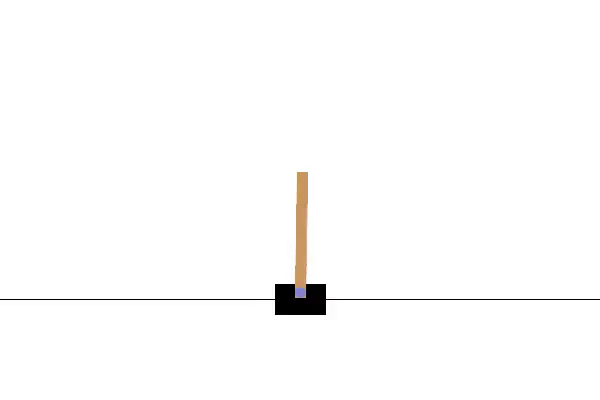

In [2]:
gym_simulation("CartPole-v1")

In [3]:
# Just for convenience, we hardcode the state and action sizes of the CartPole environment.
STATE_SIZE = 4
ACTION_SIZE = 2

### Reward Function

The Cart Pole reward function returns `+1` reward at every timestep: the idea is that the longer the
pole stays in the upright position the better. Such reward function does not encapsulate whether an
action is good or bad, and it does not play well with some concepts we are going to analyze later in
this notebook (such as normalization and custom baselines).

For this reason, we "adjust" the reward taking into account angle and position of the pole as a
heuristic to evaluate how good is the next state (to which the agent transitioned given its action).


In [4]:
def adjust_reward(next_state, reward) -> Union[np.float64, np.array]:
    angle = next_state[2] if len(next_state.shape) == 1 else next_state[:, 2]
    position = next_state[0] if len(next_state.shape) == 1 else next_state[:, 0]
    return reward - np.abs(angle) / 0.418 - np.abs(position) / 4.8

## Optimization Rule

For one trajectory $\tau$ (or episode), the neural networks weight can be updated according to:

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) R(\tau)
$$

We can interpret this as pushing up probabilities for action / states combinations when the return
is high, and the other way around for low returns.

This relationship is also interesting because only the policy function needs to be differentiable:
the reward function might very well be discontinuous and sparse.

For derivation, check the
[Hugging Face Deep RL tutorial](https://huggingface.co/learn/deep-rl-course/unit4/pg-theorem).


## REINFORCE

<div style="width: 70%">
  <img src="../assets/04_PG_reinforce.png">
  <br>
  <small>Sutton & Barto 2022</small>
</div>


In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, hidden_units=16):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(STATE_SIZE, hidden_units)
        self.fc2 = nn.Linear(hidden_units, ACTION_SIZE)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

In [6]:
class Agent:
    def __init__(self):
        self.policy = PolicyNetwork()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)

    def sample_action(self, state: np.array) -> tuple[np.array, torch.Tensor]:
        state = torch.from_numpy(state).float()
        probs = self.policy.forward(state)
        cdist = Categorical(probs)
        action = cdist.sample()
        logprob = cdist.log_prob(action)
        return action.cpu().numpy(), logprob

    def learn(self, log_probs: list[torch.Tensor], returns: Union[np.float64, np.array]):
        returns = torch.tensor(returns, dtype=torch.float64)
        log_probs = torch.stack(log_probs)
        policy_loss = -(log_probs * returns).sum()
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    @torch.no_grad
    def act(self, state):
        """Convenient method for the agent to select an action during simulation."""
        action, _ = self.sample_action(state[np.newaxis, :])
        return action[0]

In [7]:
def REINFORCE(env, agent, max_episodes=10_000, max_t=1_000, gamma=0.9999):
    scores = []
    for i_episode in range(1, max_episodes + 1):
        rewards = []
        log_probs = []
        state, _ = env.reset()

        for t in range(max_t):
            action, log_prob = agent.sample_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(adjust_reward(state, reward))
            log_probs.append(log_prob)
            if terminated or truncated:
                break

        discounts = np.power(gamma, np.arange(len(rewards)))
        R = np.sum(discounts * rewards)

        agent.learn(log_probs, R)

        # Track scores and print statistics.
        scores.append(t)
        avg_duration = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f"Episode {i_episode}\tAverage duration: {avg_duration:.2f}")
        if avg_duration >= 490.0:  # Solved
            print(f"Environment solved at episode {i_episode}\tAvg. duration: {avg_duration:.2f}")
            break

    return scores

Episode 100	Average duration: 26.34
Episode 200	Average duration: 43.98
Episode 300	Average duration: 52.59
Episode 400	Average duration: 57.74
Episode 500	Average duration: 58.74
Episode 600	Average duration: 54.20
Episode 700	Average duration: 63.39
Episode 800	Average duration: 69.86
Episode 900	Average duration: 71.14
Episode 1000	Average duration: 28.57
Episode 1100	Average duration: 35.29
Episode 1200	Average duration: 46.22
Episode 1300	Average duration: 69.53
Episode 1400	Average duration: 230.42
Episode 1500	Average duration: 97.64
Episode 1600	Average duration: 107.76
Episode 1700	Average duration: 342.11
Episode 1800	Average duration: 249.78
Episode 1900	Average duration: 157.80
Episode 2000	Average duration: 135.63
Episode 2100	Average duration: 123.46
Episode 2200	Average duration: 136.73
Episode 2300	Average duration: 128.93
Episode 2400	Average duration: 160.62
Episode 2500	Average duration: 450.79
Environment solved at episode 2516	Avg. duration: 491.08


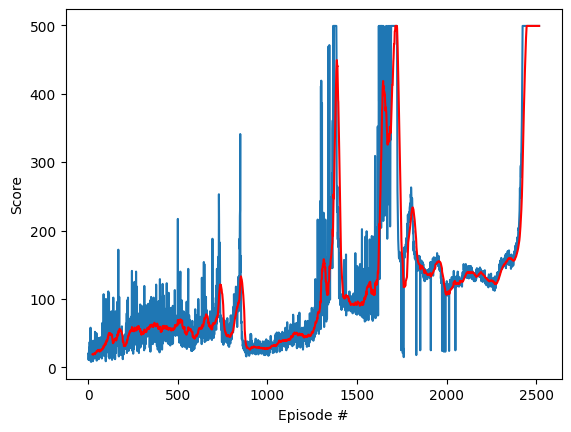

In [8]:
with init_random(gym.make("CartPole-v1")) as env:
    agent = Agent()
    scores = REINFORCE(env, agent)
plot_scores(scores)

/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


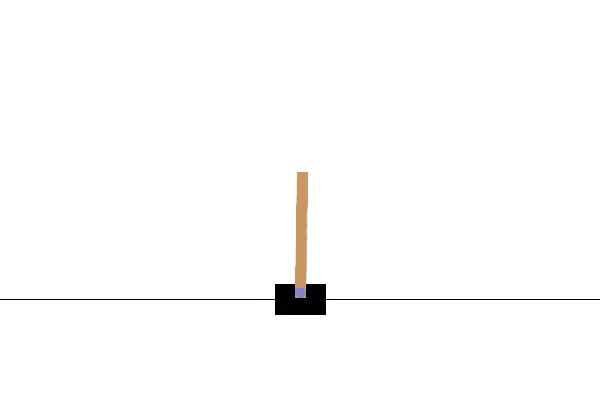

In [9]:
gym_simulation("CartPole-v1", agent)

## Improvements

### Use Future Rewards

First thing to notice is that we are using all rewards at every timestep. But really, we should only
consider future rewards: i.e., the rewards that are actually the consequences of our actions.

$$
g = \sum_t R_t^{future}\nabla_{\theta} log\pi_{\theta}(a_t | s_t)
$$

### Collect Multiple Trajectories

In every episode, we sample a single trajectory: the gradient update might not contain good data
about our policy and the stochastic updates might be very _noisy_. Learning happens because in the
long run we hope that all tiny signals accumulate and converge towards the optimal policy.

How do we reduce noise? The simplest strategy is to collect more trajectories (with the current
policy) at once! And Gymnasium vectorized environment `gym.vector.VectorEnv` serves exactly that
purpose!

#### Normalize Rewards

When collecting multiple trajectories, a technique we can use is to normalize the rewards across the
various trajectories: which roughly picks half actions to encourage / discourage, and keeps the
gradient updates moderate.

$$
R_k \leftarrow \frac{R_k - \mu}{\sigma}
$$

The rewards distribution will also likely change during training, and a reward that might be good at
the beginning might actually signal a bad trajectory in late stages of training. Normalization helps
with such cases as well.

### Baseline Subtraction

The idea is to subtract to the reward a _baseline_ $b$, for example the average reward along all
trajectories (What if every trajectory has _always_ positive returns?). In this case, things that
are above average will push their probabilities to happen up while things below average will be
penalized.

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) [R(\tau) - b(s_t)]
$$

We can do this because on expectation this extra subtracted term will have zero effect (as long as
it does not depend on the action in _logprob_), but overall we'll get reduced variance (proof left
as exercise and/or you can find it in the resources).

#### Advantage Function

This value that we multiply with the log-probability to "reinforce" or "depress" the corresponding
actions is called the _advantage function_ and plays a critical role in state-of-the-art algorithms:

$$
A(*) = R(\tau) - b
$$

It measures how better the selected action does compared to the _average_ in the state.


In [10]:
def REINFORCE_v2(
    env: gym.vector.VectorEnv,
    agent,
    max_episodes=10_000,
    max_t=1_000,
    gamma=0.9999,
    with_normalization=True,
    with_baseline=True,
):
    scores = []
    for i_episode in range(1, max_episodes + 1):
        states, rewards, log_probs = ([], [], [])
        state, _ = env.reset()

        for t in range(max_t):
            action, log_prob = agent.sample_action(state)
            log_probs.append(log_prob)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(adjust_reward(state, reward))
            states.append(state)
            if terminated.any() or truncated.any():
                break

        discounts = np.power(gamma, np.arange(len(rewards)))
        discounted_rewards = discounts[:, np.newaxis] * rewards
        future_returns = discounted_rewards[::-1].cumsum(axis=0)[::-1]  # (batch, n_bots)

        if with_baseline:
            baseline = np.asarray([states[t][:, 2] * states[t][:, 3] for t in range(len(rewards))])
            future_returns = future_returns - baseline

        if with_normalization:
            returns_mean = np.mean(future_returns, axis=1)[:, np.newaxis]
            returns_std = (
                np.std(future_returns, axis=1)[:, np.newaxis] + 1.0e-10
            )  # avoid 0 division
            future_returns = (future_returns - returns_mean) / returns_std

        # copy() for negative strides :(
        #   https://discuss.pytorch.org/t/negative-strides-in-tensor-error/134287/2
        agent.learn(log_probs, future_returns.copy())

        # Track scores and print statistics
        scores.append(t)
        avg_duration = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f"Episode {i_episode}\tAverage duration: {avg_duration:.2f}")
        if avg_duration >= 490.0:  # Solved
            print(f"Environment solved at episode {i_episode}\tAvg. duration: {avg_duration:.2f}")
            break

    return scores

Episode 100	Average duration: 42.17
Episode 200	Average duration: 421.49
Environment solved at episode 224	Avg. duration: 494.15


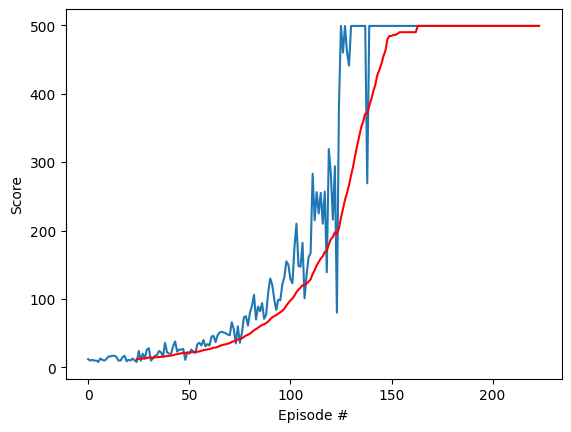

In [11]:
env = init_random(gym.make_vec("CartPole-v1", num_envs=5))
agent_v2 = Agent()
scores_v2 = REINFORCE_v2(env, agent_v2)
plot_scores(scores_v2)

MoviePy - Building file /tmp/rl-video.gif with imageio.


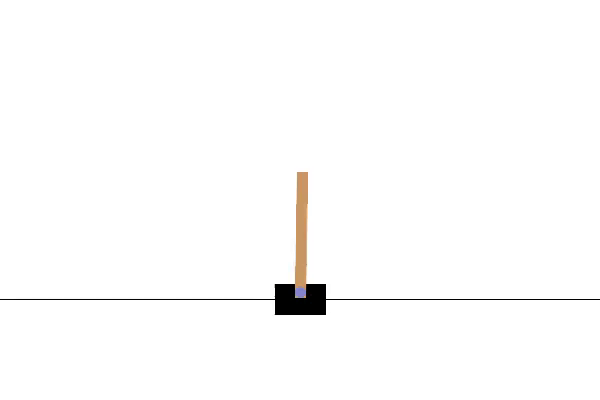

In [12]:
gym_simulation("CartPole-v1", agent_v2)

## What Can We Do Better?

There are other improvements that can be applied:

1. Actor-critic setup (with value function baseline) and advanced advantage estimation such as _GAE_
   will improve learning.
2. We are currently _discarding experiences_ after every learning step. That is because the policy
   effectively changes. But we'll see that with importance sampling we can iterate on the same data
   multiple times and learn in mini-batches!
3. Techniques such as "_trust region_" and "_loss clipping_" will help against degeneration and keep
   the policy learning along smooth gradient directions.

Once we put all of these in place... we'll have PPO!


## Appendix

### Meaning of Loss

Note that the loss function used in policy gradient methods doesn't have the same meaning of the
typical supervised learning setup. In particular, after that first step of gradient descent, there
is no more connection to performance - which is determined by the average return.

The loss function is only useful when evaluated at the current parameters to perform one step of
gradient ascent. After that it loses its meaning and it's value shouldn't be used as a metric for
performance.

More details on
[OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#id14).

### Performance Comparison

You can check how REINFORCE with future rewards + normalization + well crafted baseling performs
better than the vanilla REINFORCE.

Interesting to observe how we needed to tweak the reward function to reach these results: in fact,
formulating the reward function properly is one of the major challenges in RL and an area of open
research (e.g., curiosity driven agents).

As an exercise, try removing the adjustment of rewards in this notebook and just keep the original
Cart Pole `+1` per timestep reward. What's the effect on the algorithms' variants? Hint: check how
catastrophic learning is with normalization enabled!


Future rewards only:
Episode 100	Average duration: 28.36
Episode 200	Average duration: 235.97
Episode 300	Average duration: 173.27
Episode 400	Average duration: 157.49
Episode 500	Average duration: 434.51
Environment solved at episode 521	Avg. duration: 491.82
Future rewards + normalization:
Episode 100	Average duration: 81.76
Environment solved at episode 196	Avg. duration: 491.23
Future rewards + normalization + baseline:
Episode 100	Average duration: 125.62
Environment solved at episode 183	Avg. duration: 490.00

Future rewards only:
Episode 100	Average duration: 16.84
Episode 200	Average duration: 34.39
Episode 300	Average duration: 50.62
Episode 400	Average duration: 224.17
Episode 500	Average duration: 210.30
Episode 600	Average duration: 223.40
Environment solved at episode 695	Avg. duration: 490.19
Future rewards + normalization:
Episode 100	Average duration: 33.54
Episode 200	Average duration: 405.78
Environment solved at episode 224	Avg. duration: 490.43
Future rewards + norm

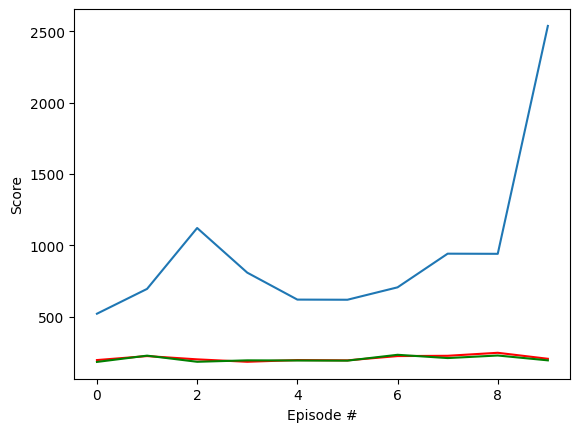

In [13]:
import matplotlib.pyplot as plt

init_random()
base, norm, all = ([], [], [])
random_seeds = np.random.randint(3_141_592, size=10)
for seed in random_seeds:
    env = init_random(gym.make_vec("CartPole-v1", num_envs=5), seed=int(seed))
    print("Future rewards only:")
    agent_v3 = Agent()
    scores_v3 = REINFORCE_v2(env, agent_v3, with_normalization=False, with_baseline=False)
    base.append(len(scores_v3))

    env = init_random(gym.make_vec("CartPole-v1", num_envs=5), seed=int(seed))
    print("Future rewards + normalization:")
    agent_v3_b = Agent()
    scores_v3_b = REINFORCE_v2(env, agent_v3_b, with_normalization=True, with_baseline=False)
    norm.append(len(scores_v3_b))

    env = init_random(gym.make_vec("CartPole-v1", num_envs=5), seed=int(seed))
    print("Future rewards + normalization + baseline:")
    agent_v3_bn = Agent()
    scores_v3_bn = REINFORCE_v2(env, agent_v3_bn, with_normalization=True, with_baseline=True)
    all.append(len(scores_v3_bn))
    print()

x = np.arange(len(norm))
plt.figure("Episode scores")
plt.plot(x, base, label="Future rewards")
plt.plot(x, norm, "r", label="Future rewards + normalization")
plt.plot(x, all, "g", label="Future rewards + normalization + baseline")
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

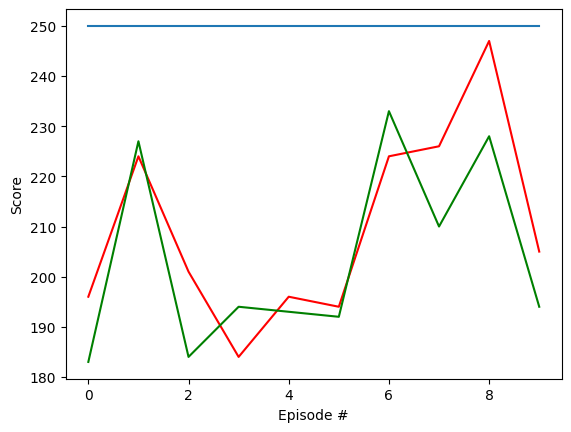

In [16]:
clipped_base = [min(x, 250) for x in base]

x = np.arange(len(norm))
plt.figure("Episode scores")
plt.plot(x, clipped_base, label="Future rewards")
plt.plot(x, norm, "r", label="Future rewards + normalization")
plt.plot(x, all, "g", label="Future rewards + normalization + baseline")
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()